In [ ]:
import pandas as pd
import os
import time
import logging
from sqlalchemy import create_engine, text

# ---------------- LOGGING SETUP ---------------- #
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[
        logging.FileHandler("pipeline.log", encoding="utf-8"),
        logging.StreamHandler()
    ]
)


# ---------------- TIMER START ---------------- #
start_time = time.time()
logging.info("Pipeline started")

# ---------------- DB CONNECTION ---------------- #
# Encode special characters: @ -> %40 , # -> %23
DB_USER = "postgres"
DB_PASS = "12345"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# ---------------- CREATE DATABASE ---------------- #
NEW_DB = "e_commerce"

with engine.connect() as conn:
    conn.execute(text("COMMIT"))
    result = conn.execute(
        text(f"SELECT 1 FROM pg_database WHERE datname='{NEW_DB}'")
    ).fetchone()

    if not result:
        conn.execute(text(f"CREATE DATABASE {NEW_DB}"))
        logging.info(f"Database '{NEW_DB}' created")
    else:
        logging.info(f"Database '{NEW_DB}' already exists")

# ---------------- CONNECT TO NEW DB ---------------- #
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{NEW_DB}"
)

# ---------------- INGEST FUNCTION ---------------- #
def ingest_db(df, table_name, engine):
    if df.empty:
        logging.warning(f"Table '{table_name}' skipped (empty DataFrame)")
        return

    df.to_sql(
        name=table_name,
        con=engine,
        if_exists='replace',
        index=False,
        method='multi',
        chunksize=1000
    )
    logging.info(f"Table '{table_name}' loaded with {len(df)} rows")

# ---------------- READ & LOAD CSV FILES ---------------- #
folder_path = r"C:\Users\adsha\all full stack project\my_data\Project2"

if not os.path.exists(folder_path):
    logging.error("Folder path does not exist")
else:
    for file in os.listdir(folder_path):
        if file.lower().endswith(".csv"):
            full_path = os.path.join(folder_path, file)
            logging.info(f"Reading file: {file}")

            try:
                df = pd.read_csv(full_path, encoding="latin1")

                if df.shape[0] == 0:
                    logging.warning(f"{file} has no rows. Skipped.")
                    continue

                table_name = file.replace(".csv", "").lower()
                ingest_db(df, table_name, engine)

            except Exception as e:
                logging.error(f"Failed to process {file}: {e}")

# ---------------- TIMER END ---------------- #
end_time = time.time()
logging.info(f"Pipeline finished in {round(end_time - start_time, 2)} seconds")


2026-02-19 21:43:48,951 | INFO | Pipeline started
2026-02-19 21:43:49,925 | INFO | Database 'e_commerce' created
2026-02-19 21:43:49,931 | INFO | Reading file: customers.csv
2026-02-19 21:44:11,797 | INFO | Table 'customers' loaded with 99441 rows
2026-02-19 21:44:11,798 | INFO | Reading file: geolocation.csv
2026-02-19 21:47:59,113 | INFO | Table 'geolocation' loaded with 1000163 rows
2026-02-19 21:47:59,116 | INFO | Reading file: orders.csv
2026-02-19 21:48:33,761 | INFO | Table 'orders' loaded with 99441 rows
2026-02-19 21:48:33,762 | INFO | Reading file: order_items.csv
2026-02-19 21:49:10,009 | INFO | Table 'order_items' loaded with 112650 rows
2026-02-19 21:49:10,010 | INFO | Reading file: payments.csv
2026-02-19 21:49:33,813 | INFO | Table 'payments' loaded with 103886 rows
2026-02-19 21:49:33,815 | INFO | Reading file: products.csv
2026-02-19 21:49:48,434 | INFO | Table 'products' loaded with 32951 rows
2026-02-19 21:49:48,436 | INFO | Reading file: sales.csv
2026-02-19 21:49:4

 List all unique cities where customers are located.

### ALL TABLE NAME

In [5]:
tables = pd.read_sql_query("""
SELECT tablename
FROM pg_catalog.pg_tables
WHERE schemaname = 'public';
""", engine)

tables

,tablename
0,customers
1,geolocation
2,orders
3,order_items
4,payments
5,products
6,sales


### Short Details of all table 

In [6]:
tables = pd.read_sql("SELECT table_name FROM information_schema.tables WHERE table_schema='public'", engine)

for table in tables['table_name']:
    print('-'*50, table, '-'*50)
    
    count_df = pd.read_sql(f'SELECT COUNT(*) AS count FROM "{table}"', engine)
    print("Count of records:", count_df['count'].values[0])
    
    df_preview = pd.read_sql(f'SELECT * FROM "{table}" LIMIT 5', engine)
    display(df_preview)

-------------------------------------------------- customers --------------------------------------------------
Count of records: 99441


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


-------------------------------------------------- geolocation --------------------------------------------------
Count of records: 1000163


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


-------------------------------------------------- orders --------------------------------------------------
Count of records: 99441


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


-------------------------------------------------- order_items --------------------------------------------------
Count of records: 112650


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


-------------------------------------------------- payments --------------------------------------------------
Count of records: 103886


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


-------------------------------------------------- products --------------------------------------------------
Count of records: 32951


,product_id,product category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,Art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sport leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,babies,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0,20.0,17.0,13.0


-------------------------------------------------- sales --------------------------------------------------
Count of records: 3095


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


### List all unique cities where customers are located.

In [8]:
import pandas as pd
import psycopg2  # PostgreSQL connector

# ==============================
# CONFIGURATION
# ==============================
DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "user": "postgres",
    "password": "12345",
    "database": "e_commerce"
}

# ==============================
# CONNECT & QUERY
# ==============================
try:
    # Connect to PostgreSQL
    conn = psycopg2.connect(**DB_CONFIG)
    cursor = conn.cursor()
    print("✅ Database Connected")

    # Query: get distinct customer cities
    query = "SELECT DISTINCT customer_city FROM customers"
    cursor.execute(query)

    # Fetch data
    data = cursor.fetchall()

    # Get column names
    columns = [desc[0] for desc in cursor.description]

    # Load into pandas DataFrame
    df = pd.DataFrame(data, columns=columns)
    print(df.head())

except Exception as e:
    print("❌ Error:", e)

finally:
    if 'conn' in locals() and conn:
        cursor.close()
        conn.close()
        print("🔒 Database connection closed")



✅ Database Connected
          customer_city
0   bom jardim de minas
1         alto rio doce
2  alvorada do gurgueia
3              batatais
4     capao da porteira
🔒 Database connection closed


### Count the number of orders placed in 2017.

In [12]:
import psycopg2

DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "user": "postgres",
    "password": "12345",
    "database": "e_commerce"
}

try:
    conn = psycopg2.connect(**DB_CONFIG)
    cur = conn.cursor()
    print("✅ Database Connected")

    # PostgreSQL query with explicit timestamp cast
    query = """
    SELECT COUNT(order_id)
    FROM orders
    WHERE EXTRACT(YEAR FROM order_purchase_timestamp::timestamp) = 2017
    """

    cur.execute(query)
    data = cur.fetchall()
    print("Total orders placed in 2017 are", data[0][0])

except Exception as e:
    print("❌ Error:", e)

finally:
    if 'conn' in locals() and conn:
        cur.close()
        conn.close()
        print("🔒 Database connection closed")


✅ Database Connected
Total orders placed in 2017 are 45101
🔒 Database connection closed


#### Find the total sales per category.

In [16]:
import pandas as pd
import psycopg2

DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "user": "postgres",
    "password": "12345",
    "database": "e_commerce"
}

try:
    conn = psycopg2.connect(**DB_CONFIG)
    cur = conn.cursor()
    print("✅ Database Connected")

    # PostgreSQL query
    query = """
    SELECT UPPER(p."product category") AS category,
           ROUND(SUM(pay."payment_value")::numeric, 2) AS sales
    FROM products p
    JOIN order_items oi ON p."product_id" = oi."product_id"
    JOIN payments pay ON pay."order_id" = oi."order_id"
    GROUP BY category
    ORDER BY sales DESC
    """

    cur.execute(query)
    data = cur.fetchall()

    # Load into pandas DataFrame
    df = pd.DataFrame(data, columns=["Category", "Sales"])
    print(df.head())

except Exception as e:
    print("❌ Error:", e)

finally:
    if 'conn' in locals() and conn:
        cur.close()
        conn.close()
        print("🔒 Database connection closed")


✅ Database Connected
               Category       Sales
0        BED TABLE BATH  1712553.67
1         HEALTH BEAUTY  1657373.12
2  COMPUTER ACCESSORIES  1585330.45
3  FURNITURE DECORATION  1430176.39
4       WATCHES PRESENT  1429216.68
🔒 Database connection closed


### Calculate the percentage of orders that were paid in installments.

In [17]:
import psycopg2

DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "user": "postgres",
    "password": "12345",
    "database": "e_commerce"
}

try:
    conn = psycopg2.connect(**DB_CONFIG)
    cur = conn.cursor()
    print("✅ Database Connected")

    # PostgreSQL query to calculate percentage of orders with installments
    query = """
    SELECT 
        (SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END)::numeric / COUNT(*) * 100) AS installment_percentage
    FROM payments
    """

    cur.execute(query)
    data = cur.fetchall()

    print("The percentage of orders that were paid in installments is", data[0][0])

except Exception as e:
    print("❌ Error:", e)

finally:
    if 'conn' in locals() and conn:
        cur.close()
        conn.close()
        print("🔒 Database connection closed")


✅ Database Connected
The percentage of orders that were paid in installments is 99.99807481277554242200
🔒 Database connection closed


### Count the number of customers from each state.

✅ Database Connected


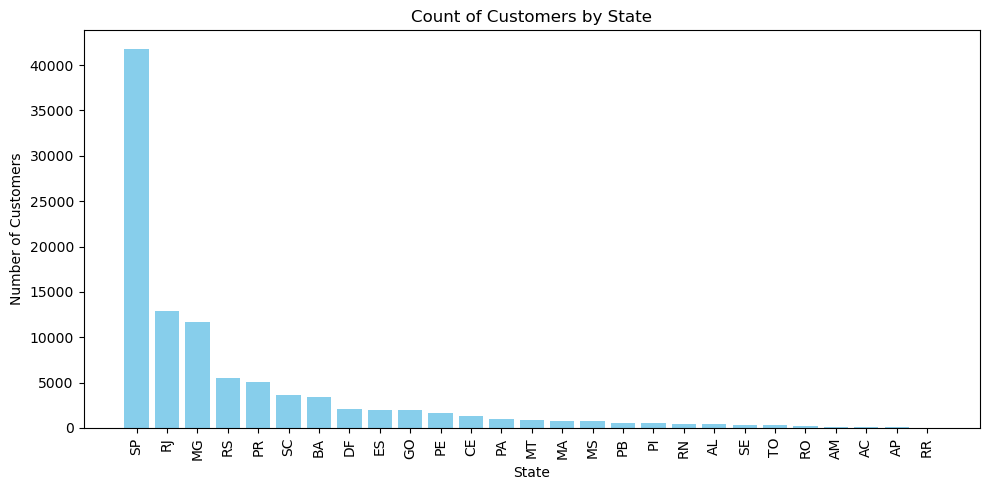

🔒 Database connection closed


In [18]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

# ==============================
# Database configuration
# ==============================
DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "user": "postgres",
    "password": "12345",
    "database": "e_commerce"
}

try:
    conn = psycopg2.connect(**DB_CONFIG)
    cur = conn.cursor()
    print("✅ Database Connected")

    # PostgreSQL query: count of customers by state
    query = """
    SELECT customer_state, COUNT(customer_id) AS customer_count
    FROM customers
    GROUP BY customer_state
    ORDER BY customer_count DESC
    """

    cur.execute(query)
    data = cur.fetchall()

    # Load into pandas DataFrame
    df = pd.DataFrame(data, columns=["state", "customer_count"])

    # ==============================
    # Plotting
    # ==============================
    plt.figure(figsize=(10, 5))
    plt.bar(df["state"], df["customer_count"], color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel("State")
    plt.ylabel("Number of Customers")
    plt.title("Count of Customers by State")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("❌ Error:", e)

finally:
    if 'conn' in locals() and conn:
        cur.close()
        conn.close()
        print("🔒 Database connection closed")


### Calculate the number of orders per month in 2018.

✅ Database Connected


2026-02-20 05:14:01,444 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-20 05:14:01,515 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


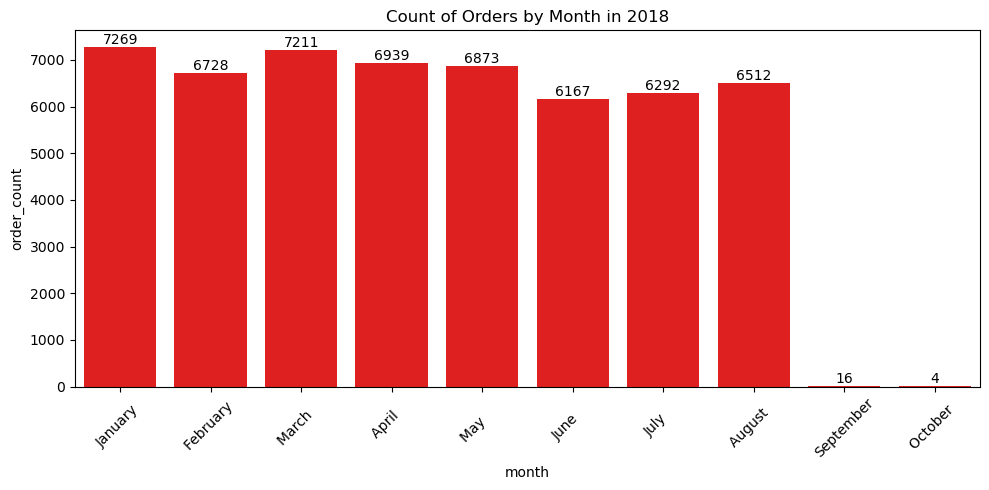

🔒 Database connection closed


In [20]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Database configuration
# ==============================
DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "user": "postgres",
    "password": "12345",
    "database": "e_commerce"
}

try:
    conn = psycopg2.connect(**DB_CONFIG)
    cur = conn.cursor()
    print("✅ Database Connected")

    # PostgreSQL query: count of orders by month in 2018
    query = """
    SELECT month_name, order_count
    FROM (
        SELECT 
            TO_CHAR(order_purchase_timestamp::timestamp, 'Month') AS month_name,
            COUNT(order_id) AS order_count,
            EXTRACT(MONTH FROM order_purchase_timestamp::timestamp) AS month_number
        FROM orders
        WHERE EXTRACT(YEAR FROM order_purchase_timestamp::timestamp) = 2018
        GROUP BY month_name, month_number
    ) sub
    ORDER BY month_number
    """

    cur.execute(query)
    data = cur.fetchall()

    # Load into pandas DataFrame
    df = pd.DataFrame(data, columns=["month", "order_count"])

    # Plot using seaborn
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x="month", y="order_count", data=df, color="red")
    plt.xticks(rotation=45)

    # Add labels on bars
    for container in ax.containers:
        ax.bar_label(container)

    plt.title("Count of Orders by Month in 2018")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("❌ Error:", e)

finally:
    if 'conn' in locals() and conn:
        cur.close()
        conn.close()
        print("🔒 Database connection closed")


### Find the average number of products per order, grouped by customer city.

In [22]:
import pandas as pd
import psycopg2

# ==============================
# DATABASE CONFIG
# ==============================
DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "user": "postgres",
    "password": "12345",
    "database": "e_commerce"
}

try:
    # Connect
    conn = psycopg2.connect(**DB_CONFIG)
    cur = conn.cursor()
    print("✅ Database Connected\n")

    # ==============================
    # QUERY
    # ==============================
    query = """
    WITH count_per_order AS (
        SELECT o.order_id,
               o.customer_id,
               COUNT(oi.order_id) AS oc
        FROM orders o
        JOIN order_items oi
            ON o.order_id = oi.order_id
        GROUP BY o.order_id, o.customer_id
    )

    SELECT c.customer_city,
           ROUND(AVG(cpo.oc)::numeric, 2) AS average_orders
    FROM customers c
    JOIN count_per_order cpo
        ON c.customer_id = cpo.customer_id
    GROUP BY c.customer_city
    ORDER BY average_orders DESC
    """

    # Execute query
    cur.execute(query)
    data = cur.fetchall()

    # ==============================
    # DATAFRAME
    # ==============================
    df = pd.DataFrame(data, columns=["Customer City", "Average Products per Order"])

    print("📊 Top 10 Cities by Avg Products per Order:\n")
    print(df.head(10))

except Exception as e:
    print("❌ Error:", e)

finally:
    # Close connection safely
    if 'cur' in locals():
        cur.close()
    if 'conn' in locals():
        conn.close()
        print("\n🔒 Database connection closed")


✅ Database Connected

📊 Top 10 Cities by Avg Products per Order:

        Customer City Average Products per Order
0      padre carvalho                       7.00
1         celso ramos                       6.50
2       candido godoi                       6.00
3               datas                       6.00
4      matias olimpio                       5.00
5  morro de sao paulo                       4.00
6          cidelandia                       4.00
7             picarra                       4.00
8          curralinho                       4.00
9     teixeira soares                       4.00

🔒 Database connection closed


### Calculate the percentage of total revenue contributed by each product category.

In [23]:
import pandas as pd
import psycopg2

DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "user": "postgres",
    "password": "12345",
    "database": "e_commerce"
}

try:
    conn = psycopg2.connect(**DB_CONFIG)
    cur = conn.cursor()
    print("✅ Database Connected")

    query = """
    SELECT 
        UPPER(p."product category") AS category,
        ROUND(
            (SUM(pay.payment_value)::numeric /
            (SELECT SUM(payment_value) FROM payments)::numeric) * 100,
            2
        ) AS sales_percentage
    FROM products p
    JOIN order_items oi ON p.product_id = oi.product_id
    JOIN payments pay ON pay.order_id = oi.order_id
    GROUP BY p."product category"
    ORDER BY sales_percentage DESC
    """

    cur.execute(query)
    data = cur.fetchall()

    df = pd.DataFrame(data, columns=["Category", "Percentage Distribution"])
    print(df.head())

except Exception as e:
    print("❌ Error:", e)

finally:
    if 'cur' in locals():
        cur.close()
    if 'conn' in locals():
        conn.close()
        print("🔒 Database connection closed")


✅ Database Connected
               Category Percentage Distribution
0        BED TABLE BATH                   10.70
1         HEALTH BEAUTY                   10.35
2  COMPUTER ACCESSORIES                    9.90
3  FURNITURE DECORATION                    8.93
4       WATCHES PRESENT                    8.93
🔒 Database connection closed


### Identify the correlation between product price and the number of times a product has been purchased.

In [24]:
import pandas as pd
import psycopg2
import numpy as np

# ==============================
# DATABASE CONFIG
# ==============================
DB_CONFIG = {
    "host": "localhost",
    "port": 5432,
    "user": "postgres",
    "password": "12345",
    "database": "e_commerce"
}

try:
    # Connect
    db = psycopg2.connect(**DB_CONFIG)
    cur = db.cursor()
    print("✅ Database Connected")

    # ==============================
    # QUERY
    # ==============================
    query = """
    SELECT 
        p."product category" AS category,
        COUNT(oi.product_id) AS order_count,
        ROUND(AVG(oi.price)::numeric,2) AS avg_price
    FROM products p
    JOIN order_items oi
        ON p.product_id = oi.product_id
    GROUP BY p."product category"
    """

    cur.execute(query)
    data = cur.fetchall()

    # ==============================
    # DATAFRAME
    # ==============================
    df = pd.DataFrame(data, columns=["Category", "order_count", "price"])

    # Convert to numeric (safe)
    arr1 = pd.to_numeric(df["order_count"])
    arr2 = pd.to_numeric(df["price"])

    # ==============================
    # CORRELATION
    # ==============================
    corr = np.corrcoef(arr1, arr2)[0, 1]

    print("\n📊 Correlation between order count and price =", round(corr, 4))

except Exception as e:
    print("❌ Error:", e)

finally:
    if 'cur' in locals():
        cur.close()
    if 'db' in locals():
        db.close()
        print("🔒 Database connection closed")


✅ Database Connected

📊 Correlation between order count and price = -0.1063
🔒 Database connection closed


### Calculate the total revenue generated by each seller, and rank them by revenue.

✅ Database Connected
                          seller_id    revenue  rank
0  7c67e1448b00f6e969d365cea6b010ab  507166.91     1
1  1025f0e2d44d7041d6cf58b6550e0bfa  308222.04     2
2  4a3ca9315b744ce9f8e9374361493884  301245.27     3
3  1f50f920176fa81dab994f9023523100  290253.42     4
4  53243585a1d6dc2643021fd1853d8905  284903.08     5
5  da8622b14eb17ae2831f4ac5b9dab84a  272219.32     6
6  4869f7a5dfa277a7dca6462dcf3b52b2  264166.12     7
7  955fee9216a65b617aa5c0531780ce60  236322.30     8
8  fa1c13f2614d7b5c4749cbc52fecda94  206513.23     9
9  7e93a43ef30c4f03f38b393420bc753a  185134.21    10


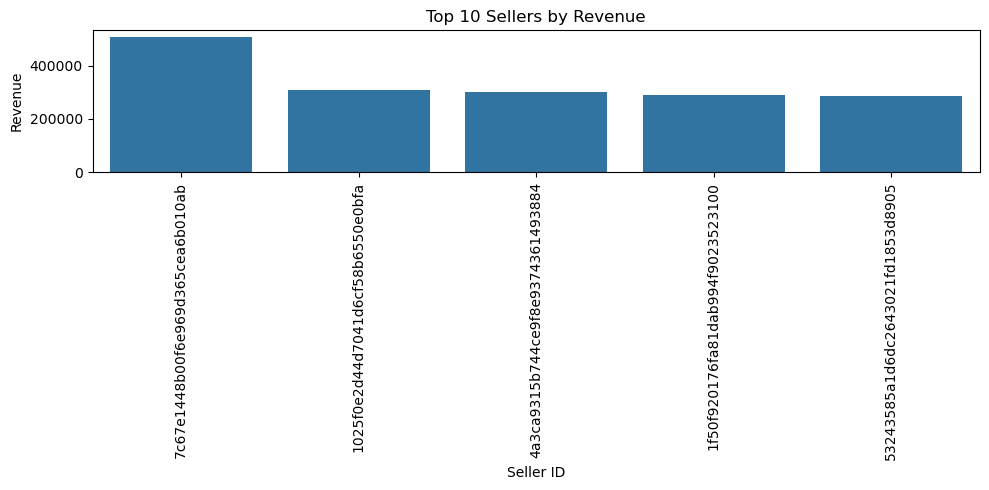

🔒 Database connection closed


In [28]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- DB CONNECTION ----------------
try:
    db_config = {
        "host": "localhost",
        "port": 5432,
        "user": "postgres",
        "password": "12345",
        "database": "e_commerce"
    }

    db = psycopg2.connect(**db_config)
    cur = db.cursor()

    print("✅ Database Connected")

except Exception as e:
    print("❌ Connection Error:", e)


# ---------------- QUERY ----------------
query = """
SELECT *,
       DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn
FROM (
        SELECT 
            order_items.seller_id,
            SUM(payments.payment_value) AS revenue
        FROM order_items
        JOIN payments
        ON order_items.order_id = payments.order_id
        GROUP BY order_items.seller_id
     ) AS a
"""

cur.execute(query)

# ---------------- FETCH DATA ----------------
data = cur.fetchall()

df = pd.DataFrame(data, columns=["seller_id", "revenue", "rank"])

# ---------------- TOP 10 SELLERS ----------------
df = df.sort_values(by="rank").head(10)

print(df)


# ---------------- VISUALIZATION ----------------
plt.figure(figsize=(10,5))
sns.barplot(x="seller_id", y="revenue", data=df.head())

plt.xticks(rotation=90)
plt.title("Top 10 Sellers by Revenue")
plt.xlabel("Seller ID")
plt.ylabel("Revenue")

plt.tight_layout()
plt.show()


# ---------------- CLOSE CONNECTION ----------------
cur.close()
db.close()

print("🔒 Database connection closed")


### Calculate the moving average of order values for each customer over their order history.

In [30]:
import psycopg2
import pandas as pd

# ---------- CONNECT ----------
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="12345",
    database="e_commerce"
)
cur = conn.cursor()


# ---------- QUERY ----------
query = """
SELECT 
    customer_id,
    order_purchase_timestamp,
    payment,
    AVG(payment) OVER (
        PARTITION BY customer_id 
        ORDER BY order_purchase_timestamp
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) AS mov_avg
FROM
(
    SELECT 
        o.customer_id,
        o.order_purchase_timestamp,
        p.payment_value AS payment
    FROM payments p
    JOIN orders o
        ON p.order_id = o.order_id
) AS a
ORDER BY customer_id, order_purchase_timestamp;
"""

cur.execute(query)
data = cur.fetchall()

# ---------- DATAFRAME ----------
columns = ["customer_id", "timestamp", "payment", "moving_avg"]
df = pd.DataFrame(data, columns=columns)

print(df)


# ---------- CLOSE ----------
cur.close()
conn.close()


                             customer_id            timestamp  payment  \
0       00012a2ce6f8dcda20d059ce98491703  2017-11-14 16:08:26   114.74   
1       000161a058600d5901f007fab4c27140  2017-07-16 09:40:32    67.41   
2       0001fd6190edaaf884bcaf3d49edf079  2017-02-28 11:06:43   195.42   
3       0002414f95344307404f0ace7a26f1d5  2017-08-16 13:09:20   179.35   
4       000379cdec625522490c315e70c7a9fb  2018-04-02 13:42:17   107.01   
...                                  ...                  ...      ...   
103881  fffecc9f79fd8c764f843e9951b11341  2018-03-29 16:59:26    71.23   
103882  fffeda5b6d849fbd39689bb92087f431  2018-05-22 13:36:02    63.13   
103883  ffff42319e9b2d713724ae527742af25  2018-06-13 16:57:05   214.13   
103884  ffffa3172527f765de70084a7e53aae8  2017-09-02 11:53:32    45.50   
103885  ffffe8b65bbe3087b653a978c870db99  2017-09-29 14:07:03    18.37   

        moving_avg  
0           114.74  
1            67.41  
2           195.42  
3           179.35  
4     

### Calculate the cumulative sales per month for each year.

In [32]:
import psycopg2
import pandas as pd

# ---------------- DATABASE CONNECTION ----------------
try:
    conn = psycopg2.connect(
        host="localhost",
        port=5432,
        user="postgres",
        password="12345",
        database="e_commerce"
    )

    cur = conn.cursor()
    print("✅ Database Connected")

    # ---------------- QUERY ----------------
    query = """
    SELECT 
        years,
        months,
        payment,
        SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales
    FROM (
            SELECT 
                EXTRACT(YEAR FROM o.order_purchase_timestamp::timestamp) AS years,
                EXTRACT(MONTH FROM o.order_purchase_timestamp::timestamp) AS months,
                ROUND(SUM(p.payment_value)::numeric, 2) AS payment
            FROM orders o
            JOIN payments p 
                ON o.order_id = p.order_id
            GROUP BY 
                EXTRACT(YEAR FROM o.order_purchase_timestamp::timestamp),
                EXTRACT(MONTH FROM o.order_purchase_timestamp::timestamp)
         ) AS a
    ORDER BY years, months;
    """

    cur.execute(query)
    data = cur.fetchall()

    # ---------------- DATAFRAME ----------------
    columns = ["year", "month", "monthly_sales", "cumulative_sales"]
    df = pd.DataFrame(data, columns=columns)

    print("\n📊 Result Preview:")
    print(df.head())

# ---------------- ERROR HANDLING ----------------
except Exception as e:
    print("❌ Error:", e)

# ---------------- CLOSE CONNECTION ----------------
finally:
    if 'cur' in locals():
        cur.close()
    if 'conn' in locals():
        conn.close()
        print("\n🔒 Database connection closed")


✅ Database Connected

📊 Result Preview:
   year month monthly_sales cumulative_sales
0  2016     9        252.24           252.24
1  2016    10      59090.48         59342.72
2  2016    12         19.62         59362.34
3  2017     1     138488.04        197850.38
4  2017     2     291908.01        489758.39

🔒 Database connection closed


### Calculate the year-over-year growth rate of total sales.

In [33]:
import psycopg2
import pandas as pd

# ---------------- DATABASE CONNECTION ----------------
try:
    conn = psycopg2.connect(
        host="localhost",
        port=5432,
        user="postgres",
        password="12345",
        database="e_commerce"
    )
    cur = conn.cursor()
    print("✅ Database Connected")

    # ---------------- QUERY ----------------
    query = """
    WITH a AS (
        SELECT 
            EXTRACT(YEAR FROM o.order_purchase_timestamp::timestamp) AS years,
            ROUND(SUM(p.payment_value)::numeric, 2) AS payment
        FROM orders o
        JOIN payments p
            ON o.order_id = p.order_id
        GROUP BY EXTRACT(YEAR FROM o.order_purchase_timestamp::timestamp)
        ORDER BY years
    )
    SELECT 
        years,
        ROUND(
            ((payment - LAG(payment, 1) OVER (ORDER BY years)) /
             LAG(payment, 1) OVER (ORDER BY years)) * 100, 2
        ) AS yoy_growth_percentage
    FROM a;
    """

    cur.execute(query)
    data = cur.fetchall()

    # ---------------- DATAFRAME ----------------
    df = pd.DataFrame(data, columns=["Year", "YoY Growth (%)"])
    print(df)

except Exception as e:
    print("❌ Error:", e)

finally:
    if 'cur' in locals():
        cur.close()
    if 'conn' in locals():
        conn.close()
        print("\n🔒 Database connection closed")


✅ Database Connected
   Year YoY Growth (%)
0  2016           None
1  2017       12112.70
2  2018          20.00

🔒 Database connection closed


### Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [34]:
import psycopg2
import pandas as pd

# ---------------- DATABASE CONNECTION ----------------
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="12345",
    database="e_commerce"
)
cur = conn.cursor()
print("✅ Database Connected")

# ---------------- QUERY ----------------
query = """
WITH a AS (
    SELECT 
        c.customer_id,
        MIN(o.order_purchase_timestamp::timestamp) AS first_order
    FROM customers c
    JOIN orders o
        ON c.customer_id = o.customer_id
    GROUP BY c.customer_id
),

b AS (
    SELECT 
        a.customer_id,
        COUNT(DISTINCT o.order_purchase_timestamp::timestamp) AS next_order
    FROM a
    JOIN orders o
        ON o.customer_id = a.customer_id
       AND o.order_purchase_timestamp::timestamp > a.first_order
       AND o.order_purchase_timestamp::timestamp < a.first_order + INTERVAL '6 months'
    GROUP BY a.customer_id
)

SELECT 
    100.0 * COUNT(DISTINCT b.customer_id)::numeric / NULLIF(COUNT(DISTINCT a.customer_id),0) AS retention_percentage
FROM a
LEFT JOIN b
    ON a.customer_id = b.customer_id;
"""

cur.execute(query)
data = cur.fetchall()

# ---------------- DATAFRAME ----------------
df = pd.DataFrame(data, columns=["Retention %"])
print(df)

# ---------------- CLOSE CONNECTION ----------------
cur.close()
conn.close()
print("🔒 Database connection closed")


✅ Database Connected
  Retention %
0       0E-24
🔒 Database connection closed


### Identify the top 3 customers who spent the most money in each year.

✅ Database Connected
   year                       customer_id   payment  rank
0  2016  a9dc96b027d1252bbac0a9b72d837fc6   1423.55     1
1  2016  1d34ed25963d5aae4cf3d7f3a4cda173   1400.74     2
2  2016  4a06381959b6670756de02e07b83815f   1227.78     3
3  2017  1617b1357756262bfa56ab541c47bc16  13664.08     1
4  2017  c6e2731c5b391845f6800c97401a43a9   6929.31     2


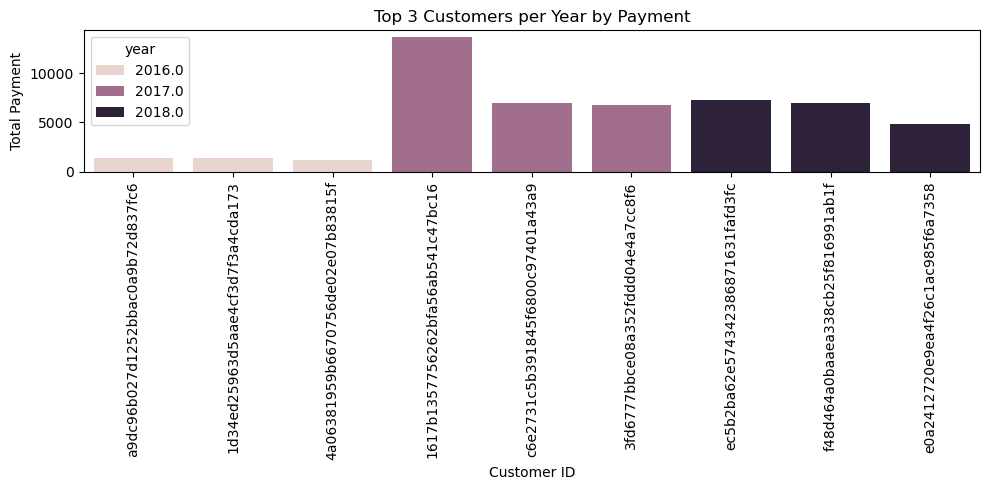

🔒 Database connection closed


In [35]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---------------- DATABASE CONNECTION ----------------
conn = psycopg2.connect(
    host="localhost",
    port=5432,
    user="postgres",
    password="12345",
    database="e_commerce"
)
cur = conn.cursor()
print("✅ Database Connected")

# ---------------- QUERY ----------------
query = """
SELECT years, customer_id, payment, d_rank
FROM (
    SELECT 
        EXTRACT(YEAR FROM o.order_purchase_timestamp::timestamp) AS years,
        o.customer_id,
        SUM(p.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY EXTRACT(YEAR FROM o.order_purchase_timestamp::timestamp)
            ORDER BY SUM(p.payment_value) DESC
        ) AS d_rank
    FROM orders o
    JOIN payments p
        ON p.order_id = o.order_id
    GROUP BY 
        EXTRACT(YEAR FROM o.order_purchase_timestamp::timestamp),
        o.customer_id
) AS a
WHERE d_rank <= 3;
"""

cur.execute(query)
data = cur.fetchall()

# ---------------- DATAFRAME ----------------
df = pd.DataFrame(data, columns=["year", "customer_id", "payment", "rank"])
print(df.head())

# ---------------- VISUALIZATION ----------------
plt.figure(figsize=(10,5))
sns.barplot(x="customer_id", y="payment", hue="year", data=df)
plt.xticks(rotation=90)
plt.title("Top 3 Customers per Year by Payment")
plt.xlabel("Customer ID")
plt.ylabel("Total Payment")
plt.tight_layout()
plt.show()

# ---------------- CLOSE CONNECTION ----------------
cur.close()
conn.close()
print("🔒 Database connection closed")
